In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sn
from tqdm import tqdm_notebook as tqdm
from scipy.stats import skew, kurtosis, iqr

In [2]:
df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()

Train samples: 307511, test samples: 48744


In [3]:
del test_df
gc.collect()

28

In [4]:
df['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
df['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)

In [5]:
df['annuity_income_percentage'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['car_to_birth_ratio'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['car_to_employ_ratio'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['children_ratio'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
df['credit_to_annuity_ratio'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['credit_to_goods_ratio'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['credit_to_income_ratio'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['days_employed_percentage'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['income_credit_percentage'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['income_per_child'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['income_per_person'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['payment_rate'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['phone_to_birth_ratio'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['phone_to_employ_ratio'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']

In [6]:
df['external_sources_weighted'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 3 + df.EXT_SOURCE_3 * 4
for function_name in ['min', 'max', 'sum', 'mean', 'nanmedian']:
    df['external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
        df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

/Users/shuozhang/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:769: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [7]:
engineered_numerical_columns  = ['annuity_income_percentage',
                                'car_to_birth_ratio',
                                'car_to_employ_ratio',
                                'children_ratio',
                                'credit_to_annuity_ratio',
                                'credit_to_goods_ratio',
                                'credit_to_income_ratio',
                                'days_employed_percentage',
                                'income_credit_percentage',
                                'income_per_child',
                                'income_per_person',
                                'payment_rate',
                                'phone_to_birth_ratio',
                                'phone_to_employ_ratio',
                                'external_sources_weighted',
                                'external_sources_min',
                                'external_sources_max',
                                'external_sources_sum',
                                'external_sources_mean',
                                'external_sources_nanmedian']

In [205]:
df_eng = df[engineered_numerical_columns + ['TARGET']]
df_eng_corr = abs(df_eng.corr())

In [206]:
df_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                        1.000000
external_sources_weighted     0.236289
external_sources_mean         0.222052
external_sources_nanmedian    0.218118
external_sources_max          0.196876
external_sources_min          0.185266
external_sources_sum          0.173322
credit_to_goods_ratio         0.069427
days_employed_percentage      0.067955
car_to_birth_ratio            0.048824
phone_to_birth_ratio          0.033991
credit_to_annuity_ratio       0.032102
car_to_employ_ratio           0.029118
children_ratio                0.021223
annuity_income_percentage     0.014265
payment_rate                  0.012704
income_per_child              0.012529
credit_to_income_ratio        0.007727
income_per_person             0.006571
income_credit_percentage      0.001817
phone_to_employ_ratio         0.000262
Name: TARGET, dtype: float64

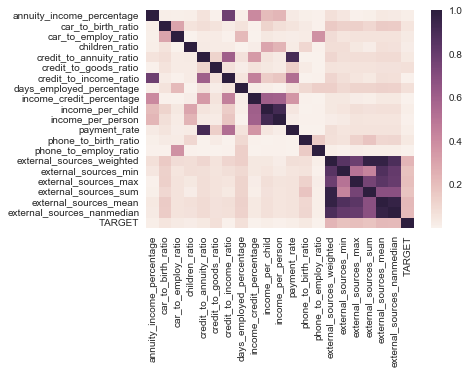

In [207]:
sns.heatmap(df_eng_corr)

In [8]:
AGGREGATION_RECIPIES = [
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                              ('AMT_CREDIT', 'max'),
                                              ('EXT_SOURCE_1', 'mean'),
                                              ('EXT_SOURCE_2', 'mean'),
                                              ('OWN_CAR_AGE', 'max'),
                                              ('OWN_CAR_AGE', 'sum')]),
    (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                            ('AMT_INCOME_TOTAL', 'mean'),
                                            ('DAYS_REGISTRATION', 'mean'),
                                            ('EXT_SOURCE_1', 'mean')]),
    (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                 ('CNT_CHILDREN', 'mean'),
                                                 ('DAYS_ID_PUBLISH', 'mean')]),
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                           ('EXT_SOURCE_2', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                  ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                  ('APARTMENTS_AVG', 'mean'),
                                                  ('BASEMENTAREA_AVG', 'mean'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('EXT_SOURCE_3', 'mean'),
                                                  ('NONLIVINGAREA_AVG', 'mean'),
                                                  ('OWN_CAR_AGE', 'mean'),
                                                  ('YEARS_BUILD_AVG', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                            ('EXT_SOURCE_1', 'mean')]),
    (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                           ('CNT_CHILDREN', 'mean'),
                           ('CNT_FAM_MEMBERS', 'mean'),
                           ('DAYS_BIRTH', 'mean'),
                           ('DAYS_EMPLOYED', 'mean'),
                           ('DAYS_ID_PUBLISH', 'mean'),
                           ('DAYS_REGISTRATION', 'mean'),
                           ('EXT_SOURCE_1', 'mean'),
                           ('EXT_SOURCE_2', 'mean'),
                           ('EXT_SOURCE_3', 'mean')]),
]

In [9]:
groupby_aggregate_names  = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = df.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        df = df.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [210]:
df_agg = df[groupby_aggregate_names + ['TARGET']]
df_agg_corr = abs(df_agg.corr())

In [211]:
df_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                                                      1.000000
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1                0.090216
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_2    0.089492
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1    0.086751
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_1                                       0.083721
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_2                                       0.082725
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_ELEVATORS_AVG               0.078333
OCCUPATION_TYPE_mean_EXT_SOURCE_1                                                           0.076804
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_NONLIVINGAREA_AVG                                  0.075561
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_AMT_REQ_CREDIT_BUREAU_YEAR                        

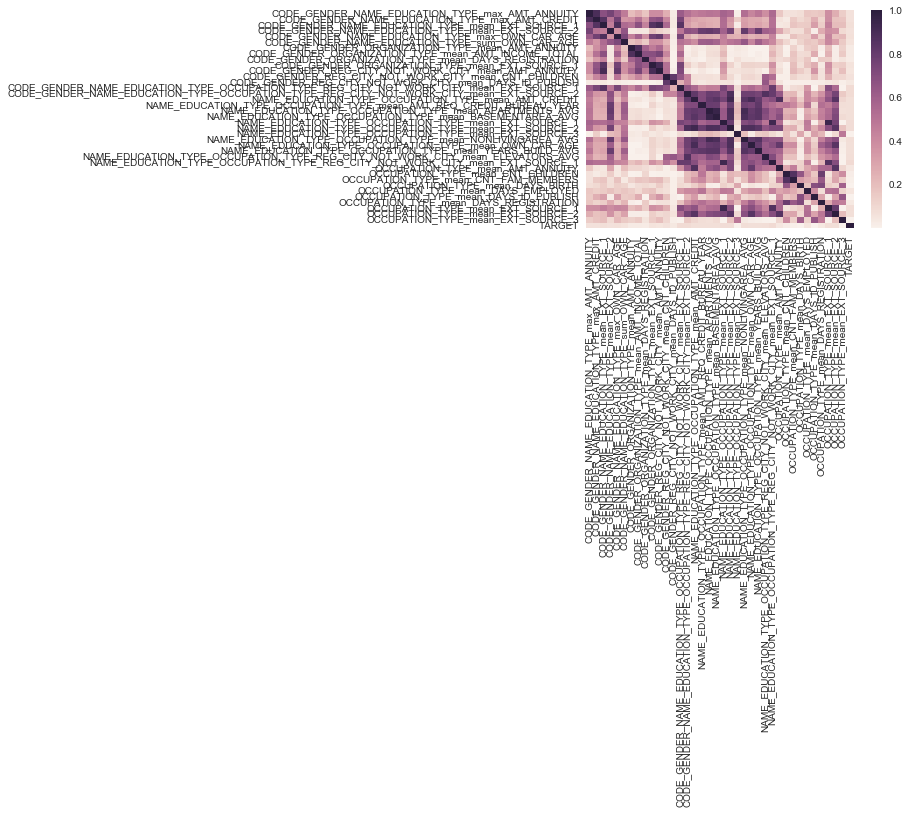

In [212]:
sns.heatmap(df_agg_corr)

In [10]:
diff_feature_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    for select, agg in tqdm(specs):
        if agg in ['mean','median','max','min']:
            groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
            diff_name = '{}_diff'.format(groupby_aggregate_name)
            abs_diff_name = '{}_abs_diff'.format(groupby_aggregate_name)

            df[diff_name] = df[select] - df[groupby_aggregate_name] 
            df[abs_diff_name] = np.abs(df[select] - df[groupby_aggregate_name]) 

            diff_feature_names.append(diff_name)
            diff_feature_names.append(abs_diff_name)

In [214]:
df_diff = df[diff_feature_names + ['TARGET']]
df_diff_corr = abs(df_diff.corr())
df_diff_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                                                               1.000000
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_3_diff                                           0.180977
OCCUPATION_TYPE_mean_EXT_SOURCE_3_diff                                                               0.180450
OCCUPATION_TYPE_mean_EXT_SOURCE_2_diff                                                               0.163087
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_2_diff                                           0.160000
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_2_diff        0.157532
CODE_GENDER_NAME_EDUCATION_TYPE_mean_EXT_SOURCE_2_diff                                               0.153578
CODE_GENDER_ORGANIZATION_TYPE_mean_EXT_SOURCE_1_diff                                                 0.147380
CODE_GENDER_NAME_EDUCATION_TYPE_mean_EXT_SOURCE_1_diff                                               0.142501
OCCUPATION

In [11]:
df['long_employment'] = (df['DAYS_EMPLOYED'] > -2000).astype(int)

In [12]:
df['retirement_age'] = (df['DAYS_BIRTH'] > -14000).astype(int)

In [13]:
df['cnt_non_child'] = df['CNT_FAM_MEMBERS'] - df['CNT_CHILDREN']
df['child_to_non_child_ratio'] = df['CNT_CHILDREN'] / df['cnt_non_child']
df['income_per_non_child'] = df['AMT_INCOME_TOTAL'] / df['cnt_non_child']
df['credit_per_person'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']
df['credit_per_child'] = df['AMT_CREDIT'] / (1 + df['CNT_CHILDREN'])
df['credit_per_non_child'] = df['AMT_CREDIT'] / df['cnt_non_child']

In [14]:
df.shape

(356255, 260)

In [219]:
feature_names = ['cnt_non_child',
                 'child_to_non_child_ratio',
                 'income_per_non_child',
                 'credit_per_person',
                 'credit_per_child',
                 'credit_per_non_child']

In [220]:
df_family = df[feature_names + ['TARGET']]
df_family_corr = abs(df_family.corr())
df_family_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                      1.000000
credit_per_child            0.033503
credit_per_person           0.023462
child_to_non_child_ratio    0.020943
credit_per_non_child        0.020244
cnt_non_child               0.012195
income_per_non_child        0.001947
Name: TARGET, dtype: float64

In [221]:
df.shape

(356255, 260)

In [15]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

In [16]:
categorical_columns

['CODE_GENDER',
 'EMERGENCYSTATE_MODE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'NAME_CONTRACT_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE',
 'WEEKDAY_APPR_PROCESS_START']

In [17]:
len(categorical_columns)

16

In [18]:
bureau = pd.read_csv('bureau.csv')
#bb = pd.read_csv('bureau_balance.csv')

In [19]:
bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] < -40000] = np.nan
bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] < -40000] = np.nan
bureau['DAYS_ENDDATE_FACT'][bureau['DAYS_ENDDATE_FACT'] < -40000] = np.nan

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing 

In [20]:
bureau['AMT_CREDIT_SUM'].fillna(0, inplace=True)
bureau['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace=True)
bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0, inplace=True)
bureau['CNT_CREDIT_PROLONG'].fillna(0, inplace=True)

In [21]:
bureau['bureau_credit_active_binary'] = (bureau['CREDIT_ACTIVE'] != 'Closed').astype(int)
bureau['bureau_credit_enddate_binary'] = (bureau['DAYS_CREDIT_ENDDATE'] > 0).astype(int)

groupby_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])

In [22]:
features = pd.DataFrame({'SK_ID_CURR':bureau['SK_ID_CURR'].unique()})

In [23]:
group_object = groupby_SK_ID_CURR['DAYS_CREDIT'].agg('count').reset_index()
group_object.rename(index=str, columns={'DAYS_CREDIT': 'bureau_number_of_past_loans'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans
0,215354,11
1,162297,6
2,402440,1
3,238881,8
4,222183,8


In [24]:
group_object = groupby_SK_ID_CURR['CREDIT_TYPE'].agg('nunique').reset_index()
group_object.rename(index=str, columns={'CREDIT_TYPE': 'bureau_number_of_loan_types'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types
0,215354,11,3
1,162297,6,3
2,402440,1,1
3,238881,8,2
4,222183,8,3


In [25]:
features['bureau_average_of_past_loans_per_type'] = \
    features['bureau_number_of_past_loans'] / features['bureau_number_of_loan_types']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type
0,215354,11,3,3.666667
1,162297,6,3,2.000000
2,402440,1,1,1.000000
3,238881,8,2,4.000000
4,222183,8,3,2.666667


In [26]:
group_object = groupby_SK_ID_CURR['bureau_credit_active_binary'].agg('mean').reset_index()

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary
0,215354,11,3,3.666667,0.545455
1,162297,6,3,2.000000,0.500000
2,402440,1,1,1.000000,1.000000
3,238881,8,2,4.000000,0.375000
4,222183,8,3,2.666667,0.625000


In [27]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM_DEBT'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM_DEBT': 'bureau_total_customer_debt'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt
0,215354,11,3,3.666667,0.545455,284463.18
1,162297,6,3,2.000000,0.500000,0.00
2,402440,1,1,1.000000,1.000000,76905.00
3,238881,8,2,4.000000,0.375000,552730.50
4,222183,8,3,2.666667,0.625000,1185081.84


In [28]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM': 'bureau_total_customer_credit'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30
1,162297,6,3,2.000000,0.500000,0.00,8230386.15
2,402440,1,1,1.000000,1.000000,76905.00,89910.00
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00


In [29]:
features['bureau_debt_credit_ratio'] = \
    features['bureau_total_customer_debt'] / features['bureau_total_customer_credit']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538


In [30]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM_OVERDUE'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM_OVERDUE': 'bureau_total_customer_overdue'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0


In [31]:
features['bureau_overdue_debt_ratio'] = \
    features['bureau_total_customer_overdue'] / features['bureau_total_customer_debt']
    
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0


In [32]:
group_object = groupby_SK_ID_CURR['CNT_CREDIT_PROLONG'].agg('sum').reset_index()
group_object.rename(index=str, columns={'CNT_CREDIT_PROLONG': 'bureau_average_creditdays_prolonged'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,bureau_average_creditdays_prolonged
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0,0
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN,0
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0,0
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0,0
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0,0


In [33]:
group_object = groupby_SK_ID_CURR['bureau_credit_enddate_binary'].agg('mean').reset_index()
group_object.rename(index=str, columns={'bureau_credit_enddate_binary': 'bureau_credit_enddate_percentage'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_total_customer_debt,bureau_total_customer_credit,bureau_debt_credit_ratio,bureau_total_customer_overdue,bureau_overdue_debt_ratio,bureau_average_creditdays_prolonged,bureau_credit_enddate_percentage
0,215354,11,3,3.666667,0.545455,284463.18,5973945.30,0.047617,0.0,0.0,0,0.454545
1,162297,6,3,2.000000,0.500000,0.00,8230386.15,0.000000,0.0,NaN,0,0.166667
2,402440,1,1,1.000000,1.000000,76905.00,89910.00,0.855355,0.0,0.0,0,1.000000
3,238881,8,2,4.000000,0.375000,552730.50,1285239.06,0.430060,0.0,0.0,0,0.125000
4,222183,8,3,2.666667,0.625000,1185081.84,7158960.00,0.165538,0.0,0.0,0,0.625000


In [34]:
df = df.merge(features,
            left_on=['SK_ID_CURR'],
            right_on=['SK_ID_CURR'],
            how='left')

In [35]:
df.shape

(356255, 271)

In [36]:
del features
gc.collect()

406

In [243]:
engineered_numerical_columns = list(features.columns)
engineered_numerical_columns.remove('SK_ID_CURR')
bureau_eng = df[engineered_numerical_columns + ['TARGET']]
bureau_eng_corr = abs(bureau_eng.corr())

In [244]:
bureau_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                   1.000000
bureau_credit_active_binary              0.079369
bureau_debt_credit_ratio                 0.060235
bureau_credit_enddate_percentage         0.055305
bureau_total_customer_credit             0.014057
bureau_total_customer_overdue            0.013335
bureau_total_customer_debt               0.007144
bureau_average_of_past_loans_per_type    0.006118
bureau_number_of_loan_types              0.004624
bureau_average_creditdays_prolonged      0.004058
bureau_number_of_past_loans              0.004056
bureau_overdue_debt_ratio                0.000939
Name: TARGET, dtype: float64

In [37]:
BUREAU_AGGREGATION_RECIPIES  = [('CREDIT_TYPE', 'count'),
                               ('CREDIT_ACTIVE', 'size')
                               ]
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_ANNUITY',
                   'AMT_CREDIT_SUM',
                   'AMT_CREDIT_SUM_DEBT',
                   'AMT_CREDIT_SUM_LIMIT',
                   'AMT_CREDIT_SUM_OVERDUE',
                   'AMT_CREDIT_MAX_OVERDUE',
                   'CNT_CREDIT_PROLONG',
                   'CREDIT_DAY_OVERDUE',
                   'DAYS_CREDIT',
                   'DAYS_CREDIT_ENDDATE',
                   'DAYS_CREDIT_UPDATE'
                   ]:
        BUREAU_AGGREGATION_RECIPIES.append((select, agg))
BUREAU_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], BUREAU_AGGREGATION_RECIPIES)]

In [246]:
BUREAU_AGGREGATION_RECIPIES

[(['SK_ID_CURR'],
  [('CREDIT_TYPE', 'count'),
   ('CREDIT_ACTIVE', 'size'),
   ('AMT_ANNUITY', 'mean'),
   ('AMT_CREDIT_SUM', 'mean'),
   ('AMT_CREDIT_SUM_DEBT', 'mean'),
   ('AMT_CREDIT_SUM_LIMIT', 'mean'),
   ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
   ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
   ('CNT_CREDIT_PROLONG', 'mean'),
   ('CREDIT_DAY_OVERDUE', 'mean'),
   ('DAYS_CREDIT', 'mean'),
   ('DAYS_CREDIT_ENDDATE', 'mean'),
   ('DAYS_CREDIT_UPDATE', 'mean'),
   ('AMT_ANNUITY', 'min'),
   ('AMT_CREDIT_SUM', 'min'),
   ('AMT_CREDIT_SUM_DEBT', 'min'),
   ('AMT_CREDIT_SUM_LIMIT', 'min'),
   ('AMT_CREDIT_SUM_OVERDUE', 'min'),
   ('AMT_CREDIT_MAX_OVERDUE', 'min'),
   ('CNT_CREDIT_PROLONG', 'min'),
   ('CREDIT_DAY_OVERDUE', 'min'),
   ('DAYS_CREDIT', 'min'),
   ('DAYS_CREDIT_ENDDATE', 'min'),
   ('DAYS_CREDIT_UPDATE', 'min'),
   ('AMT_ANNUITY', 'max'),
   ('AMT_CREDIT_SUM', 'max'),
   ('AMT_CREDIT_SUM_DEBT', 'max'),
   ('AMT_CREDIT_SUM_LIMIT', 'max'),
   ('AMT_CREDIT_SUM_OVERDUE', 'max'),
   ('AMT_C

In [38]:
#57
groupby_aggregate_namesgroupby  = []
for groupby_cols, specs in tqdm(BUREAU_AGGREGATION_RECIPIES):
    group_object = bureau.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        df = df.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name}),
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [39]:
df.shape

(356255, 328)

In [249]:
df.columns

Index([                                u'index',
                                 u'AMT_ANNUITY',
                                  u'AMT_CREDIT',
                             u'AMT_GOODS_PRICE',
                            u'AMT_INCOME_TOTAL',
                   u'AMT_REQ_CREDIT_BUREAU_DAY',
                  u'AMT_REQ_CREDIT_BUREAU_HOUR',
                   u'AMT_REQ_CREDIT_BUREAU_MON',
                   u'AMT_REQ_CREDIT_BUREAU_QRT',
                  u'AMT_REQ_CREDIT_BUREAU_WEEK',
       ...
               u'SK_ID_CURR_var_AMT_CREDIT_SUM',
          u'SK_ID_CURR_var_AMT_CREDIT_SUM_DEBT',
         u'SK_ID_CURR_var_AMT_CREDIT_SUM_LIMIT',
       u'SK_ID_CURR_var_AMT_CREDIT_SUM_OVERDUE',
       u'SK_ID_CURR_var_AMT_CREDIT_MAX_OVERDUE',
           u'SK_ID_CURR_var_CNT_CREDIT_PROLONG',
           u'SK_ID_CURR_var_CREDIT_DAY_OVERDUE',
                  u'SK_ID_CURR_var_DAYS_CREDIT',
          u'SK_ID_CURR_var_DAYS_CREDIT_ENDDATE',
           u'SK_ID_CURR_var_DAYS_CREDIT_UPDATE'],
      dt

In [40]:
credit_card = pd.read_csv('credit_card_balance.csv')

In [41]:
credit_card['AMT_DRAWINGS_ATM_CURRENT'][credit_card['AMT_DRAWINGS_ATM_CURRENT'] < 0] = np.nan
credit_card['AMT_DRAWINGS_CURRENT'][credit_card['AMT_DRAWINGS_CURRENT'] < 0] = np.nan

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
credit_card['number_of_instalments'] = credit_card.groupby(
    by=['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].agg('max').reset_index()[
    'CNT_INSTALMENT_MATURE_CUM']

credit_card['credit_card_max_loading_of_credit_limit'] = credit_card.groupby(
    by=['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL']).apply(
    lambda x: x.AMT_BALANCE.max() / x.AMT_CREDIT_LIMIT_ACTUAL.max()).reset_index()[0]

/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/Users/shuozhang/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [43]:
features = pd.DataFrame({'SK_ID_CURR':credit_card['SK_ID_CURR'].unique()})
features.head()

,SK_ID_CURR
0,378907
1,363914
2,371185
3,337855
4,126868


In [44]:
group_object = credit_card.groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].agg('nunique').reset_index()
group_object.rename(index=str, columns={'SK_ID_PREV': 'credit_card_number_of_loans'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans
0,378907,1
1,363914,1
2,371185,1
3,337855,1
4,126868,1


In [45]:
features['credit_card_number_of_loans'].value_counts()

1    102818
2       732
3         7
4         1
Name: credit_card_number_of_loans, dtype: int64

In [46]:
group_object= credit_card.groupby(by=['SK_ID_CURR'])['number_of_instalments'].sum().reset_index()
group_object.rename(index=str, columns={'number_of_instalments': 'credit_card_total_instalments'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments
0,378907,1,0.0
1,363914,1,94.0
2,371185,1,63.0
3,337855,1,0.0
4,126868,1,23.0


In [257]:
features['credit_card_total_instalments'].value_counts()[:10]

0.0     10641
5.0      1541
6.0      1507
7.0      1431
8.0      1278
9.0      1167
10.0     1062
Name: credit_card_total_instalments, dtype: int64

In [47]:
features['credit_card_installments_per_loan'] = (
    features['credit_card_total_instalments'] / features['credit_card_number_of_loans'])
    
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan
0,378907,1,0.0,0.0
1,363914,1,94.0,94.0
2,371185,1,63.0,63.0
3,337855,1,0.0,0.0
4,126868,1,23.0,23.0


In [48]:
group_object = credit_card.groupby(by=['SK_ID_CURR'])['credit_card_max_loading_of_credit_limit'].agg('mean').reset_index()
group_object.rename(index=str, columns={'credit_card_max_loading_of_credit_limit': 'credit_card_avg_loading_of_credit_limit'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit
0,378907,1,0.0,0.0,0.696487
1,363914,1,94.0,94.0,0.202349
2,371185,1,63.0,63.0,0.525000
3,337855,1,0.0,0.0,0.000000
4,126868,1,23.0,23.0,1.043303


In [49]:
group_object = credit_card.groupby(
    by=['SK_ID_CURR'])['SK_DPD'].agg('mean').reset_index()
group_object.rename(index=str, columns={'SK_DPD': 'credit_card_average_of_days_past_due'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit,credit_card_average_of_days_past_due
0,378907,1,0.0,0.0,0.696487,0.127660
1,363914,1,94.0,94.0,0.202349,0.010417
2,371185,1,63.0,63.0,0.525000,0.000000
3,337855,1,0.0,0.0,0.000000,0.000000
4,126868,1,23.0,23.0,1.043303,0.010417


In [50]:
group_object = credit_card.groupby(by=['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_DRAWINGS_ATM_CURRENT': 'credit_card_drawings_atm'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit,credit_card_average_of_days_past_due,credit_card_drawings_atm
0,378907,1,0.0,0.0,0.696487,0.127660,67500.0
1,363914,1,94.0,94.0,0.202349,0.010417,293850.0
2,371185,1,63.0,63.0,0.525000,0.000000,506250.0
3,337855,1,0.0,0.0,0.000000,0.000000,50850.0
4,126868,1,23.0,23.0,1.043303,0.010417,763650.0


In [51]:
group_object = credit_card.groupby(by=['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_DRAWINGS_CURRENT': 'credit_card_drawings_total'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit,credit_card_average_of_days_past_due,credit_card_drawings_atm,credit_card_drawings_total
0,378907,1,0.0,0.0,0.696487,0.127660,67500.0,124941.645
1,363914,1,94.0,94.0,0.202349,0.010417,293850.0,358313.670
2,371185,1,63.0,63.0,0.525000,0.000000,506250.0,699566.715
3,337855,1,0.0,0.0,0.000000,0.000000,50850.0,259850.835
4,126868,1,23.0,23.0,1.043303,0.010417,763650.0,1372493.385


In [52]:
features['credit_card_cash_card_ratio'] = features['credit_card_drawings_atm'] / features['credit_card_drawings_total']

features.head()

,SK_ID_CURR,credit_card_number_of_loans,credit_card_total_instalments,credit_card_installments_per_loan,credit_card_avg_loading_of_credit_limit,credit_card_average_of_days_past_due,credit_card_drawings_atm,credit_card_drawings_total,credit_card_cash_card_ratio
0,378907,1,0.0,0.0,0.696487,0.127660,67500.0,124941.645,0.540252
1,363914,1,94.0,94.0,0.202349,0.010417,293850.0,358313.670,0.820092
2,371185,1,63.0,63.0,0.525000,0.000000,506250.0,699566.715,0.723662
3,337855,1,0.0,0.0,0.000000,0.000000,50850.0,259850.835,0.195689
4,126868,1,23.0,23.0,1.043303,0.010417,763650.0,1372493.385,0.556396


In [53]:
df = df.merge(features,
              left_on=['SK_ID_CURR'],
               right_on=['SK_ID_CURR'],
              how='left')

In [265]:
engineered_numerical_columns  = list(features.columns)
engineered_numerical_columns.remove('SK_ID_CURR')
credit_eng = df[engineered_numerical_columns + ['TARGET']]
credit_eng_corr = abs(credit_eng.corr())

In [266]:
credit_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                     1.000000
credit_card_drawings_total                 0.023680
credit_card_drawings_atm                   0.009770
credit_card_installments_per_loan          0.006356
credit_card_total_instalments              0.005746
credit_card_number_of_loans                0.004388
credit_card_average_of_days_past_due       0.003195
credit_card_avg_loading_of_credit_limit    0.002944
credit_card_cash_card_ratio                0.002414
Name: TARGET, dtype: float64

In [54]:
df.shape

(356255, 336)

In [56]:
del features,group_object
gc.collect()

204

In [57]:
CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_BALANCE',
                   'AMT_CREDIT_LIMIT_ACTUAL',
                   'AMT_DRAWINGS_ATM_CURRENT',
                   'AMT_DRAWINGS_CURRENT',
                   'AMT_DRAWINGS_OTHER_CURRENT',
                   'AMT_DRAWINGS_POS_CURRENT',
                   'AMT_PAYMENT_CURRENT',
                   'CNT_DRAWINGS_ATM_CURRENT',
                   'CNT_DRAWINGS_CURRENT',
                   'CNT_DRAWINGS_OTHER_CURRENT',
                   'CNT_INSTALMENT_MATURE_CUM',
                   'MONTHS_BALANCE',
                   'SK_DPD',
                   'SK_DPD_DEF'
                   ]:
        CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES.append((select, agg))
CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES)]

In [269]:
CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES

[(['SK_ID_CURR'],
  [('AMT_BALANCE', 'mean'),
   ('AMT_CREDIT_LIMIT_ACTUAL', 'mean'),
   ('AMT_DRAWINGS_ATM_CURRENT', 'mean'),
   ('AMT_DRAWINGS_CURRENT', 'mean'),
   ('AMT_DRAWINGS_OTHER_CURRENT', 'mean'),
   ('AMT_DRAWINGS_POS_CURRENT', 'mean'),
   ('AMT_PAYMENT_CURRENT', 'mean'),
   ('CNT_DRAWINGS_ATM_CURRENT', 'mean'),
   ('CNT_DRAWINGS_CURRENT', 'mean'),
   ('CNT_DRAWINGS_OTHER_CURRENT', 'mean'),
   ('CNT_INSTALMENT_MATURE_CUM', 'mean'),
   ('MONTHS_BALANCE', 'mean'),
   ('SK_DPD', 'mean'),
   ('SK_DPD_DEF', 'mean'),
   ('AMT_BALANCE', 'min'),
   ('AMT_CREDIT_LIMIT_ACTUAL', 'min'),
   ('AMT_DRAWINGS_ATM_CURRENT', 'min'),
   ('AMT_DRAWINGS_CURRENT', 'min'),
   ('AMT_DRAWINGS_OTHER_CURRENT', 'min'),
   ('AMT_DRAWINGS_POS_CURRENT', 'min'),
   ('AMT_PAYMENT_CURRENT', 'min'),
   ('CNT_DRAWINGS_ATM_CURRENT', 'min'),
   ('CNT_DRAWINGS_CURRENT', 'min'),
   ('CNT_DRAWINGS_OTHER_CURRENT', 'min'),
   ('CNT_INSTALMENT_MATURE_CUM', 'min'),
   ('MONTHS_BALANCE', 'min'),
   ('SK_DPD', 'min'),
  

In [58]:
groupby_aggregate_names= []
for groupby_cols, specs in tqdm(CREDIT_CARD_BALANCE_AGGREGATION_RECIPIES):
    group_object = credit_card.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        df = df.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [59]:
df.shape

(356255, 406)

In [272]:
application_agg = df[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [273]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                        1.000000
SK_ID_CURR_mean_CNT_DRAWINGS_ATM_CURRENT      0.107692
SK_ID_CURR_max_CNT_DRAWINGS_CURRENT           0.101389
SK_ID_CURR_mean_AMT_BALANCE                   0.087177
SK_ID_CURR_mean_CNT_DRAWINGS_CURRENT          0.082520
SK_ID_CURR_max_AMT_BALANCE                    0.068798
SK_ID_CURR_min_AMT_BALANCE                    0.064163
SK_ID_CURR_max_CNT_DRAWINGS_ATM_CURRENT       0.063729
SK_ID_CURR_var_CNT_DRAWINGS_CURRENT           0.062892
SK_ID_CURR_mean_MONTHS_BALANCE                0.062081
SK_ID_CURR_min_MONTHS_BALANCE                 0.061359
SK_ID_CURR_var_CNT_DRAWINGS_ATM_CURRENT       0.061123
SK_ID_CURR_mean_AMT_DRAWINGS_ATM_CURRENT      0.059925
SK_ID_CURR_sum_MONTHS_BALANCE                 0.059051
SK_ID_CURR_var_MONTHS_BALANCE                 0.058817
SK_ID_CURR_mean_AMT_DRAWINGS_CURRENT          0.058732
SK_ID_CURR_max_AMT_DRAWINGS_CURRENT           0.052318
SK_ID_CURR_sum_CNT_DRAWINGS_CURRENT           0.050685
SK_ID_CURR

In [60]:
installments = pd.read_csv('installments_payments.csv')

In [61]:
INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_INSTALMENT',
                   'AMT_PAYMENT',
                   'DAYS_ENTRY_PAYMENT',
                   'DAYS_INSTALMENT',
                   'NUM_INSTALMENT_NUMBER',
                   'NUM_INSTALMENT_VERSION'
                   ]:
        INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES.append((select, agg))
INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES)]

In [62]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES):
    group_object = installments.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        df = df.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [63]:
df.shape

(356255, 436)

In [278]:
application_agg = df[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [279]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                    1.000000
SK_ID_CURR_min_DAYS_ENTRY_PAYMENT         0.058794
SK_ID_CURR_min_DAYS_INSTALMENT            0.058648
SK_ID_CURR_var_DAYS_INSTALMENT            0.052273
SK_ID_CURR_var_DAYS_ENTRY_PAYMENT         0.052071
SK_ID_CURR_mean_DAYS_ENTRY_PAYMENT        0.043992
SK_ID_CURR_mean_DAYS_INSTALMENT           0.043509
SK_ID_CURR_sum_DAYS_ENTRY_PAYMENT         0.035225
SK_ID_CURR_sum_DAYS_INSTALMENT            0.035064
SK_ID_CURR_min_NUM_INSTALMENT_VERSION     0.032039
SK_ID_CURR_sum_NUM_INSTALMENT_VERSION     0.030063
SK_ID_CURR_mean_NUM_INSTALMENT_VERSION    0.027323
SK_ID_CURR_min_AMT_PAYMENT                0.025724
SK_ID_CURR_sum_AMT_PAYMENT                0.024373
SK_ID_CURR_mean_AMT_PAYMENT               0.023169
SK_ID_CURR_min_AMT_INSTALMENT             0.020257
SK_ID_CURR_sum_AMT_INSTALMENT             0.019811
SK_ID_CURR_max_NUM_INSTALMENT_VERSION     0.018611
SK_ID_CURR_mean_AMT_INSTALMENT            0.018409
SK_ID_CURR_sum_NUM_INSTALMENT_N

In [64]:
installments['instalment_paid_late_in_days'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT'] 
installments['instalment_paid_late'] = (installments['instalment_paid_late_in_days'] > 0).astype(int)
installments['instalment_paid_over_amount'] = installments['AMT_PAYMENT'] - installments['AMT_INSTALMENT']
installments['instalment_paid_over'] = (installments['instalment_paid_over_amount'] > 0).astype(int)

In [65]:
def add_features(feature_name, aggs, features, feature_names, groupby):
    feature_names.extend(['{}_{}'.format(feature_name, agg) for agg in aggs])

    for agg in aggs:
        if agg == 'kurt':
            agg_func = kurtosis
        elif agg == 'iqr':
            agg_func = iqr
        else:
            agg_func = agg
        
        g = groupby[feature_name].agg(agg_func).reset_index().rename(index=str,
                                                                columns={feature_name: '{}_{}'.format(feature_name,
                                                                                                      agg)})
        features = features.merge(g, on='SK_ID_CURR', how='left')
    return features, feature_names

In [88]:
features = pd.DataFrame({'SK_ID_CURR':installments['SK_ID_CURR'].unique()})
groupby = installments.groupby(['SK_ID_CURR'])

In [89]:
feature_names = []

features, feature_names = add_features('NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                     features, feature_names, groupby)

In [90]:
features, feature_names = add_features('instalment_paid_late_in_days', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_late', ['sum','mean'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_over_amount', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_over', ['sum','mean'],
                                     features, feature_names, groupby)

In [91]:
features.shape

(339587, 32)

In [75]:
def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features

In [76]:
def last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'],ascending=False, inplace=True)
    
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]

        features = add_features_in_group(features,gr_period, 'NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        
        features = add_features_in_group(features,gr_period, 'instalment_paid_late_in_days', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'instalment_paid_late', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'instalment_paid_over_amount', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period,'instalment_paid_over', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))        
    
    return features

In [345]:
installments.shape

(13605401, 12)

In [77]:
import logging
import os
import random
import sys
import multiprocessing as mp
from functools import reduce

import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import yaml

In [78]:
def parallel_apply(groups, func, index_name='Index', num_workers=1, chunk_size=100000):
    n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
    indeces, features = [], []
    for index_chunk, groups_chunk in tqdm(chunk_groups(groups, chunk_size), total=n_chunks):
        Pool= mp.pool.Pool(num_workers) 
        features_chunk = Pool.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)
        Pool.close()
        Pool.join()

    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features

In [79]:
import copy
def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)

        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = copy.copy(group_chunk), copy.copy(index_chunk)
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_

In [80]:
from functools import partial
sys.path.append('../')

In [81]:
func = partial(last_k_instalment_features, periods=[1,5,10,20,50,100])
g = parallel_apply(groupby, func, index_name='SK_ID_CURR',num_workers=16, chunk_size=10000).reset_index()
#features = features.merge(g, on='SK_ID_CURR', how='left')

100%|██████████| 34/34.0 [1:35:07<00:00, 167.87s/it]


In [82]:
g.head()

,SK_ID_CURR,last_100_NUM_INSTALMENT_VERSION_iqr,last_100_NUM_INSTALMENT_VERSION_kurt,last_100_NUM_INSTALMENT_VERSION_max,last_100_NUM_INSTALMENT_VERSION_mean,last_100_NUM_INSTALMENT_VERSION_median,last_100_NUM_INSTALMENT_VERSION_min,last_100_NUM_INSTALMENT_VERSION_skew,last_100_NUM_INSTALMENT_VERSION_std,last_100_NUM_INSTALMENT_VERSION_sum,...,last_5_instalment_paid_over_amount_kurt,last_5_instalment_paid_over_amount_max,last_5_instalment_paid_over_amount_mean,last_5_instalment_paid_over_amount_median,last_5_instalment_paid_over_amount_min,last_5_instalment_paid_over_amount_skew,last_5_instalment_paid_over_amount_std,last_5_instalment_paid_over_amount_sum,last_5_instalment_paid_over_count,last_5_instalment_paid_over_mean
0,100001,0.0,2.166667,2.0,1.142857,1.0,1.0,2.041241,0.377964,8.0,...,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0
1,100002,0.0,14.055556,2.0,1.052632,1.0,1.0,4.006938,0.229416,20.0,...,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0
2,100003,0.0,20.041667,2.0,1.040000,1.0,1.0,4.694855,0.200000,26.0,...,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0
3,100004,0.5,-1.500000,2.0,1.333333,1.0,1.0,0.707107,0.577350,4.0,...,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
4,100005,0.0,4.125000,2.0,1.111111,1.0,1.0,2.474874,0.333333,10.0,...,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0


In [83]:
g.shape

(339587, 187)

In [92]:
features = features.merge(g, on='SK_ID_CURR', how='left')
features.shape

(339587, 218)

In [93]:
del g
gc.collect()

260

In [94]:
from sklearn.linear_model import LinearRegression

In [95]:
def trend_in_last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'],ascending=False, inplace=True)
    
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]


        features = _add_trend_feature(features,gr_period,
                                      'instalment_paid_late_in_days','{}_period_trend_'.format(period)
                                     )
        features = _add_trend_feature(features,gr_period,
                                      'instalment_paid_over_amount','{}_period_trend_'.format(period)
                                     )
    return features

In [96]:
def _add_trend_feature(features,gr,feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0,len(y)).reshape(-1,1)
        lr = LinearRegression()
        lr.fit(x,y)
        trend = lr.coef_[0]
    except:
        trend=np.nan
    features['{}{}'.format(prefix,feature_name)] = trend
    return features

In [97]:
func = partial(trend_in_last_k_instalment_features, periods=[10,50,100,500])

g = parallel_apply(groupby, func, index_name='SK_ID_CURR',
                   num_workers=16, chunk_size=10000).reset_index()

100%|██████████| 34/34.0 [37:19<00:00, 65.87s/it]


In [98]:
g.head()

,SK_ID_CURR,100_period_trend_instalment_paid_late_in_days,100_period_trend_instalment_paid_over_amount,10_period_trend_instalment_paid_late_in_days,10_period_trend_instalment_paid_over_amount,500_period_trend_instalment_paid_late_in_days,500_period_trend_instalment_paid_over_amount,50_period_trend_instalment_paid_late_in_days,50_period_trend_instalment_paid_over_amount
0,100001,3.821429,0.0,3.821429,0.0,3.821429,0.0,3.821429,0.0
1,100002,-0.568421,0.0,0.012121,0.0,-0.568421,0.0,-0.568421,0.0
2,100003,-0.085385,0.0,-0.193939,0.0,-0.085385,0.0,-0.085385,0.0
3,100004,-4.000000,0.0,-4.000000,0.0,-4.000000,0.0,-4.000000,0.0
4,100005,-2.816667,0.0,-2.816667,0.0,-2.816667,0.0,-2.816667,0.0


In [99]:
features = features.merge(g, on='SK_ID_CURR', how='left')

In [100]:
features.shape

(339587, 226)

In [101]:
del g
gc.collect()

42

In [102]:
def last_k_instalment_features_with_fractions(gr, periods, fraction_periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'],ascending=False, inplace=True)
    
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]

        features = add_features_in_group(features,gr_period, 'NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        
        features = add_features_in_group(features,gr_period, 'instalment_paid_late_in_days', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'instalment_paid_late', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'instalment_paid_over_amount', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period,'instalment_paid_over', 
                                     ['count','mean'],
                                         'last_{}_'.format(period)) 
    for short_period, long_period in fraction_periods:
        short_feature_names = _get_feature_names(features, short_period)
        long_feature_names = _get_feature_names(features, long_period)
        
        for short_feature, long_feature in zip(short_feature_names, long_feature_names):
            old_name_chunk = '_{}_'.format(short_period)
            new_name_chunk ='_{}by{}_fraction_'.format(short_period, long_period)
            fraction_feature_name = short_feature.replace(old_name_chunk, new_name_chunk)
            features[fraction_feature_name] = safe_div(features[short_feature], features[long_feature])
    return pd.Series(features)

def _get_feature_names(features, period):
    return sorted([feat for feat in features.keys() if '_{}_'.format(period) in feat])


def safe_div(a,b):
    try:
        return float(a)/float(b)
    except:
        return 0.0

In [103]:
func = partial(last_k_instalment_features_with_fractions, 
               periods=[1,5,10,20,50,100],
               fraction_periods=[(5,20),(5,50),(10,100)])

g = parallel_apply(groupby, func, index_name='SK_ID_CURR',
                   num_workers=16, chunk_size=1000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

100%|██████████| 340/340.0 [2:09:42<00:00, 22.89s/it]  


In [104]:
features.shape

(339587, 505)

In [105]:
del g
gc.collect()

2377144

In [106]:
df =df.merge(features, on=['SK_ID_CURR'], how='left')

In [107]:
df.shape

(356255, 940)

In [108]:
del features
gc.collect()

14

In [109]:
pos_cash_balance=pd.read_csv('POS_CASH_balance.csv')

In [110]:
POS_CASH_BALANCE_AGGREGATION_RECIPIES = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['MONTHS_BALANCE',
                   'SK_DPD',
                   'SK_DPD_DEF'
                   ]:
        POS_CASH_BALANCE_AGGREGATION_RECIPIES.append((select, agg))
POS_CASH_BALANCE_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], POS_CASH_BALANCE_AGGREGATION_RECIPIES)]

In [111]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(POS_CASH_BALANCE_AGGREGATION_RECIPIES):
    group_object = pos_cash_balance.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        df = df.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

100%|██████████| 1/1 [01:26<00:00, 86.72s/it]


In [112]:
features  = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})

In [113]:
pos_cash_sorted = pos_cash_balance.sort_values(['SK_ID_CURR', 'MONTHS_BALANCE'])
group_object = pos_cash_sorted.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].last().reset_index()
group_object.rename(index=str,
                    columns={'CNT_INSTALMENT_FUTURE': 'pos_cash_remaining_installments'},
                    inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [114]:
features.shape

(337252, 2)

In [115]:
pos_cash_balance['is_contract_status_completed'] = pos_cash_balance['NAME_CONTRACT_STATUS'] == 'Completed'
group_object = pos_cash_balance.groupby(['SK_ID_CURR'])['is_contract_status_completed'].sum().reset_index()
group_object.rename(index=str,
                    columns={'is_contract_status_completed': 'pos_cash_completed_contracts'},
                    inplace=True)
features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [116]:
features.shape

(337252, 3)

In [117]:
pos_cash_balance['pos_cash_paid_late'] = (pos_cash_balance['SK_DPD'] > 0).astype(int)
pos_cash_balance['pos_cash_paid_late_with_tolerance'] = (pos_cash_balance['SK_DPD_DEF'] > 0).astype(int)
groupby = pos_cash_balance.groupby(['SK_ID_CURR'])

In [118]:
def last_k_installment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)

    features = {}
    for period in periods:
        if period > 10e10:
            period_name = 'all_installment_'
            gr_period = gr_.copy()
        else:
            period_name = 'last_{}_'.format(period)
            gr_period = gr_.iloc[:period]

        features = add_features_in_group(features, gr_period, 'pos_cash_paid_late',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'pos_cash_paid_late_with_tolerance',
                                             ['count', 'mean'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD',
                                             ['sum', 'mean', 'max', 'min', 'median'],
                                             period_name)
        features = add_features_in_group(features, gr_period, 'SK_DPD_DEF',
                                             ['sum', 'mean', 'max', 'min','median'],
                                             period_name)
    return features

In [119]:
features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})
func = partial(last_k_installment_features, periods=[1, 10, 50, 10e16])
g = parallel_apply(groupby, func, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

100%|██████████| 34/34.0 [26:39<00:00, 47.04s/it]


In [120]:
features.shape

(337252, 57)

In [121]:
del g
gc.collect()

41

In [122]:
def last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features={}
    features = add_features_in_group(features, gr_, 'pos_cash_paid_late',
                                         ['count', 'sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'pos_cash_paid_late_with_tolerance',
                                         ['sum', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_, 'SK_DPD_DEF',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    return features

In [123]:
features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})
g = parallel_apply(groupby, last_loan_features, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

100%|██████████| 34/34.0 [14:36<00:00, 25.78s/it]


In [124]:
features.shape

(337252, 16)

In [125]:
del g
gc.collect()

41

In [126]:
def trend_in_last_k_installment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['MONTHS_BALANCE'], ascending=False, inplace=True)

    features = {}
    for period in periods:
        gr_period = gr_.iloc[:period]

        features = add_trend_feature(features, gr_period,
                                         'SK_DPD', '{}_period_trend_'.format(period)
                                         )
        features = add_trend_feature(features, gr_period,
                                         'SK_DPD_DEF', '{}_period_trend_'.format(period)
                                         )
    return features

def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features

In [127]:
features = pd.DataFrame({'SK_ID_CURR': pos_cash_balance['SK_ID_CURR'].unique()})
func = partial(trend_in_last_k_installment_features, periods=[1,6,12,30,60])
g = parallel_apply(groupby, func, index_name='SK_ID_CURR', num_workers=10, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

100%|██████████| 34/34.0 [23:59<00:00, 42.34s/it]


In [128]:
features.shape

(337252, 11)

In [129]:
del g
gc.collect()

41

In [130]:
df = df.merge(features, on='SK_ID_CURR',how='left')

In [131]:
df.shape

(356255, 965)

In [132]:
del features
gc.collect()

14

In [133]:
previous_application=pd.read_csv('previous_application.csv')

In [134]:
previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

In [135]:
PREVIOUS_APPLICATION_AGGREGATION_RECIPIES = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_ANNUITY',
                   'AMT_APPLICATION',
                   'AMT_CREDIT',
                   'AMT_DOWN_PAYMENT',
                   'AMT_GOODS_PRICE',
                   'CNT_PAYMENT',
                   'DAYS_DECISION',
                   'HOUR_APPR_PROCESS_START',
                   'RATE_DOWN_PAYMENT'
                   ]:
        PREVIOUS_APPLICATION_AGGREGATION_RECIPIES.append((select, agg))
PREVIOUS_APPLICATION_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], PREVIOUS_APPLICATION_AGGREGATION_RECIPIES)]

In [136]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(PREVIOUS_APPLICATION_AGGREGATION_RECIPIES):
    group_object = previous_application.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        df = df.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

100%|██████████| 1/1 [03:49<00:00, 229.93s/it]


In [137]:
df.shape

(356255, 1010)

In [138]:
numbers_of_applications = [1, 3, 5]

In [139]:
features = pd.DataFrame({'SK_ID_CURR': previous_application['SK_ID_CURR'].unique()})
prev_applications_sorted = previous_application.sort_values(['SK_ID_CURR', 'DAYS_DECISION'])

In [140]:
group_object = prev_applications_sorted.groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index()
group_object.rename(index=str,
                    columns={'SK_ID_PREV': 'previous_application_number_of_prev_application'},
                    inplace=True)
features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [141]:
prev_applications_sorted['previous_application_prev_was_approved'] = (
        prev_applications_sorted['NAME_CONTRACT_STATUS'] == 'Approved').astype('int')
group_object = prev_applications_sorted.groupby(by=['SK_ID_CURR'])[
    'previous_application_prev_was_approved'].last().reset_index()
features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [142]:
prev_applications_sorted['previous_application_prev_was_refused'] = (
        prev_applications_sorted['NAME_CONTRACT_STATUS'] == 'Refused').astype('int')
group_object = prev_applications_sorted.groupby(by=['SK_ID_CURR'])[
    'previous_application_prev_was_refused'].last().reset_index()
features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [143]:
for number in numbers_of_applications:
    prev_applications_tail = prev_applications_sorted.groupby(by=['SK_ID_CURR']).tail(number)

    group_object = prev_applications_tail.groupby(by=['SK_ID_CURR'])['CNT_PAYMENT'].mean().reset_index()
    group_object.rename(index=str, columns={
        'CNT_PAYMENT': 'previous_application_term_of_last_{}_credits_mean'.format(number)},
                        inplace=True)
    features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

    group_object = prev_applications_tail.groupby(by=['SK_ID_CURR'])['DAYS_DECISION'].mean().reset_index()
    group_object.rename(index=str, columns={
        'DAYS_DECISION': 'previous_application_days_decision_about_last_{}_credits_mean'.format(number)},
                        inplace=True)
    features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

    group_object = prev_applications_tail.groupby(by=['SK_ID_CURR'])['DAYS_FIRST_DRAWING'].mean().reset_index()
    group_object.rename(index=str, columns={
        'DAYS_FIRST_DRAWING': 'previous_application_days_first_drawing_last_{}_credits_mean'.format(number)},
                        inplace=True)
    features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [144]:
features.shape

(338857, 13)

In [145]:
df = df.merge(features,
                                left_on=['SK_ID_CURR'],
                                right_on=['SK_ID_CURR'],
                                how='left')

In [146]:
df.shape

(356255, 1022)

In [149]:
df.columns

Index([                                                       u'index',
                                                        u'AMT_ANNUITY',
                                                         u'AMT_CREDIT',
                                                    u'AMT_GOODS_PRICE',
                                                   u'AMT_INCOME_TOTAL',
                                          u'AMT_REQ_CREDIT_BUREAU_DAY',
                                         u'AMT_REQ_CREDIT_BUREAU_HOUR',
                                          u'AMT_REQ_CREDIT_BUREAU_MON',
                                          u'AMT_REQ_CREDIT_BUREAU_QRT',
                                         u'AMT_REQ_CREDIT_BUREAU_WEEK',
       ...
                              u'previous_application_prev_was_refused',
                   u'previous_application_term_of_last_1_credits_mean',
       u'previous_application_days_decision_about_last_1_credits_mean',
        u'previous_application_days_first_drawing_las

In [147]:
del features
gc.collect()

35

In [148]:
df.to_csv('df_1000.csv',index=False)

In [232]:
df=pd.read_csv('df_1000.csv')

In [233]:
df.shape

(356255, 1022)

In [188]:
import category_encoders as ce

In [238]:
categorical_columns=['CODE_GENDER',
                       'EMERGENCYSTATE_MODE',
                       'FLAG_CONT_MOBILE',
                       'FLAG_DOCUMENT_3',
                       'FLAG_DOCUMENT_4',
                       'FLAG_DOCUMENT_5',
                       'FLAG_DOCUMENT_6',
                       'FLAG_DOCUMENT_7',
                       'FLAG_DOCUMENT_8',
                       'FLAG_DOCUMENT_9',
                       'FLAG_DOCUMENT_11',
                       'FLAG_DOCUMENT_18',
                       'FLAG_EMAIL',
                       'FLAG_EMP_PHONE',
                       'FLAG_MOBIL',
                       'FLAG_OWN_CAR',
                       'FLAG_OWN_REALTY',
                       'FLAG_PHONE',
                       'FLAG_WORK_PHONE',
                       'FONDKAPREMONT_MODE',
                       'HOUR_APPR_PROCESS_START',
                       'HOUSETYPE_MODE',
                       'LIVE_CITY_NOT_WORK_CITY',
                       'LIVE_REGION_NOT_WORK_REGION',
                       'NAME_CONTRACT_TYPE',
                       'NAME_TYPE_SUITE',
                       'NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE',
                       'NAME_FAMILY_STATUS',
                       'NAME_HOUSING_TYPE',
                       'OCCUPATION_TYPE',
                       'ORGANIZATION_TYPE',
                       'REG_CITY_NOT_LIVE_CITY',
                       'REG_CITY_NOT_WORK_CITY',
                       'REG_REGION_NOT_LIVE_REGION',
                       'REG_REGION_NOT_WORK_REGION',
                       'WALLSMATERIAL_MODE',
                       'WEEKDAY_APPR_PROCESS_START']

In [239]:
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [240]:
for col in categorical_columns:
    df[col] = pd.Categorical(df[col].cat.codes+1)

In [241]:
df[categorical_columns].head()

,CODE_GENDER,EMERGENCYSTATE_MODE,FLAG_CONT_MOBILE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,...,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START
0,2,1,2,2,1,1,1,1,1,1,...,4,2,9,6,1,1,1,1,6,7
1,1,1,2,2,1,1,1,1,1,1,...,2,2,4,40,1,1,1,1,1,2
2,2,0,2,1,1,1,1,1,1,1,...,4,2,9,12,1,1,1,1,0,2
3,1,0,2,2,1,1,1,1,1,1,...,1,2,9,6,1,1,1,1,0,7
4,2,0,2,1,1,1,1,1,2,1,...,4,2,4,38,1,2,1,1,0,5


In [252]:
for col in categorical_columns:
    df[col] = df[col].astype(int)

In [253]:
df.shape

(356255, 1022)

In [254]:
df[categorical_columns].dtypes

CODE_GENDER                    int64
EMERGENCYSTATE_MODE            int64
FLAG_CONT_MOBILE               int64
FLAG_DOCUMENT_3                int64
FLAG_DOCUMENT_4                int64
FLAG_DOCUMENT_5                int64
FLAG_DOCUMENT_6                int64
FLAG_DOCUMENT_7                int64
FLAG_DOCUMENT_8                int64
FLAG_DOCUMENT_9                int64
FLAG_DOCUMENT_11               int64
FLAG_DOCUMENT_18               int64
FLAG_EMAIL                     int64
FLAG_EMP_PHONE                 int64
FLAG_MOBIL                     int64
FLAG_OWN_CAR                   int64
FLAG_OWN_REALTY                int64
FLAG_PHONE                     int64
FLAG_WORK_PHONE                int64
FONDKAPREMONT_MODE             int64
HOUR_APPR_PROCESS_START        int64
HOUSETYPE_MODE                 int64
LIVE_CITY_NOT_WORK_CITY        int64
LIVE_REGION_NOT_WORK_REGION    int64
NAME_CONTRACT_TYPE             int64
NAME_TYPE_SUITE                int64
NAME_INCOME_TYPE               int64
N

In [255]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Starting LightGBM. Train shape: (307511, 1022), test shape: (48744, 1022)


In [256]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [257]:
train_df[feats].shape

(307511, 1019)

In [258]:
test_df[categorical_columns].shape

(48744, 38)

In [259]:
import lightgbm as lgb

In [270]:
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                         label=train_df['TARGET'].iloc[train_idx],
                         feature_name=feats,
                         categorical_feature=categorical_columns)
    dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx],
                         label=train_df['TARGET'].iloc[valid_idx],
                         feature_name=feats,
                         categorical_feature=categorical_columns)
    params = {'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric':'auc',
              'learning_rate': 0.02,
              'num_leaves': 30, 
              'max_depth': -1,  
              'min_child_samples': 70,  
              'max_bin': 300,  
              'subsample': 1.0,  
              'subsample_freq': 1,  
              'colsample_bytree': 0.05,  
              'min_split_gain': 0.5,
              'min_child_weight': 4,
              'reg_lambda': 100.0,
              'reg_alpha': 0.0,
              'scale_pos_weight':1, 
              'is_balance': False,
              'nthread': 8,
              'verbose': -1,}
    
    clf = lgb.train(params, 
                      dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train','valid'],
                      num_boost_round=5000,
                      early_stopping_rounds=100,
                      verbose_eval=50)

    oof_preds[valid_idx] = clf.predict(train_df[feats].iloc[valid_idx])
    sub_preds += clf.predict(test_df[feats]) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(train_df['TARGET'].iloc[valid_idx], oof_preds[valid_idx])))
    del clf, dtrain, dvalid
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
sub_df = test_df[['SK_ID_CURR']].copy()
sub_df['TARGET'] = sub_preds
sub_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_1000feature.csv', index= False)

Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.745666	valid's auc: 0.741921
[100]	train's auc: 0.756542	valid's auc: 0.750188
[150]	train's auc: 0.768493	valid's auc: 0.759182
[200]	train's auc: 0.777024	valid's auc: 0.765911
[250]	train's auc: 0.783373	valid's auc: 0.770635
[300]	train's auc: 0.788551	valid's auc: 0.774405
[350]	train's auc: 0.793195	valid's auc: 0.777429
[400]	train's auc: 0.797107	valid's auc: 0.779818
[450]	train's auc: 0.800655	valid's auc: 0.781767
[500]	train's auc: 0.803926	valid's auc: 0.783418
[550]	train's auc: 0.806805	valid's auc: 0.784603
[600]	train's auc: 0.80964	valid's auc: 0.785766
[650]	train's auc: 0.812371	valid's auc: 0.786743
[700]	train's auc: 0.815013	valid's auc: 0.787779
[750]	train's auc: 0.817563	valid's auc: 0.788674
[800]	train's auc: 0.819949	valid's auc: 0.789347
[850]	train's auc: 0.822401	valid's auc: 0.790124
[900]	train's auc: 0.824715	valid's auc: 0.7907
[950]	train's auc: 0.826909	valid's auc: 

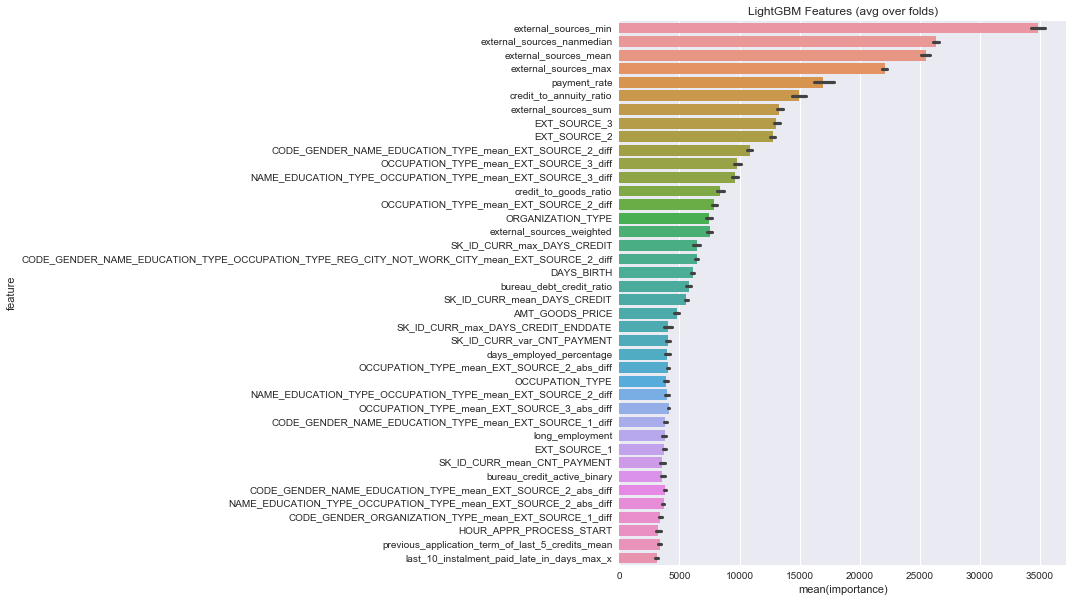

In [271]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.show()

In [272]:
feature_importance_df.to_csv('feature_importance_lgb1000features.csv', index=False)

In [273]:
feature_sort=best_features.sort_values(by="importance", ascending=False)

In [278]:
USELESS_COLUMNS = ['FLAG_DOCUMENT_10',
                   'FLAG_DOCUMENT_12',
                   'FLAG_DOCUMENT_13',
                   'FLAG_DOCUMENT_14',
                   'FLAG_DOCUMENT_15',
                   'FLAG_DOCUMENT_16',
                   'FLAG_DOCUMENT_17',
                   'FLAG_DOCUMENT_19',
                   'FLAG_DOCUMENT_2',
                   'FLAG_DOCUMENT_20',
                   'FLAG_DOCUMENT_21']

In [282]:
df= df.drop(USELESS_COLUMNS,axis=1)

In [283]:
df.shape

(356255, 1011)

In [284]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Starting LightGBM. Train shape: (307511, 1011), test shape: (48744, 1011)


In [285]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [286]:
categorical_columns=['CODE_GENDER',
                       'EMERGENCYSTATE_MODE',
                       'FLAG_CONT_MOBILE',
                       'FLAG_DOCUMENT_3',
                       'FLAG_DOCUMENT_4',
                       'FLAG_DOCUMENT_5',
                       'FLAG_DOCUMENT_6',
                       'FLAG_DOCUMENT_7',
                       'FLAG_DOCUMENT_8',
                       'FLAG_DOCUMENT_9',
                       'FLAG_DOCUMENT_11',
                       'FLAG_DOCUMENT_18',
                       'FLAG_EMAIL',
                       'FLAG_EMP_PHONE',
                       'FLAG_MOBIL',
                       'FLAG_OWN_CAR',
                       'FLAG_OWN_REALTY',
                       'FLAG_PHONE',
                       'FLAG_WORK_PHONE',
                       'FONDKAPREMONT_MODE',
                       'HOUR_APPR_PROCESS_START',
                       'HOUSETYPE_MODE',
                       'LIVE_CITY_NOT_WORK_CITY',
                       'LIVE_REGION_NOT_WORK_REGION',
                       'NAME_CONTRACT_TYPE',
                       'NAME_TYPE_SUITE',
                       'NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE',
                       'NAME_FAMILY_STATUS',
                       'NAME_HOUSING_TYPE',
                       'OCCUPATION_TYPE',
                       'ORGANIZATION_TYPE',
                       'REG_CITY_NOT_LIVE_CITY',
                       'REG_CITY_NOT_WORK_CITY',
                       'REG_REGION_NOT_LIVE_REGION',
                       'REG_REGION_NOT_WORK_REGION',
                       'WALLSMATERIAL_MODE',
                       'WEEKDAY_APPR_PROCESS_START']

In [ ]:
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                         label=train_df['TARGET'].iloc[train_idx],
                         feature_name=feats,
                         categorical_feature=categorical_columns)
    dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx],
                         label=train_df['TARGET'].iloc[valid_idx],
                         feature_name=feats,
                         categorical_feature=categorical_columns)
    params = {'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric':'auc',
              'learning_rate': 0.02,
              'num_leaves': 30, 
              'max_depth': -1,  
              'min_child_samples': 70,  
              'max_bin': 300,  
              'subsample': 1.0,  
              'subsample_freq': 1,  
              'colsample_bytree': 0.05,  
              'min_split_gain': 0.5,
              'min_child_weight': 4,
              'reg_lambda': 100.0,
              'reg_alpha': 0.0,
              'scale_pos_weight':1, 
              'is_balance': False,
              'nthread': 8,
              'verbose': -1,}
    
    clf = lgb.train(params, 
                      dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train','valid'],
                      num_boost_round=5000,
                      early_stopping_rounds=100,
                      verbose_eval=50)

    oof_preds[valid_idx] = clf.predict(train_df[feats].iloc[valid_idx])
    sub_preds += clf.predict(test_df[feats]) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(train_df['TARGET'].iloc[valid_idx], oof_preds[valid_idx])))
    del clf, dtrain, dvalid
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
sub_df = test_df[['SK_ID_CURR']].copy()
sub_df['TARGET'] = sub_preds
sub_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_1000feature_drop.csv', index= False)

Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.744481	valid's auc: 0.740819
[100]	train's auc: 0.758238	valid's auc: 0.751723
[150]	train's auc: 0.76862	valid's auc: 0.759116
[200]	train's auc: 0.776346	valid's auc: 0.765317
[250]	train's auc: 0.782774	valid's auc: 0.769979
[300]	train's auc: 0.788523	valid's auc: 0.774293
[350]	train's auc: 0.792699	valid's auc: 0.776773
[400]	train's auc: 0.796557	valid's auc: 0.779238
[450]	train's auc: 0.800016	valid's auc: 0.78108
[500]	train's auc: 0.803396	valid's auc: 0.782741
[550]	train's auc: 0.806559	valid's auc: 0.784184
[600]	train's auc: 0.809552	valid's auc: 0.785581
[650]	train's auc: 0.812308	valid's auc: 0.786713
[700]	train's auc: 0.815072	valid's auc: 0.787727
[750]	train's auc: 0.817655	valid's auc: 0.788841
[800]	train's auc: 0.82016	valid's auc: 0.789605
[850]	train's auc: 0.822508	valid's auc: 0.790227
[900]	train's auc: 0.824827	valid's auc: 0.790889
[950]	train's auc: 0.827081	valid's auc: 